<h1><center>Stock Trend Prediction </center></h1>
<h1><center> Using Machine Learning Algorithms </center></h1>
<h3><center>Yanyan Guan, Peiwen Li</center></h3>

## Abstract 
The main purpose of this project is to compare two machine learning algorithms that can be used to predict the trend of the stock market. Specifically, our discussion is based on the Logistic algorithm and the Support Vector Machine (SVM) algorithm. After researching, we found many previous works have discussed the best performance model when predicting the stock market prices. Our goal is to compare the prediction generated by Logistic and SVM algorithms with the actual trend of the stock using the real historical data of two different stocks (AAPL and MSFT). The study of the stock prediction method has great application value and significance for both large institutions and individual investors.

## Introduction
During the past few decades, the stock market prediction has become a topic that draws an increasing amount of attention from the public. An accurate analysis of the stock market trend in the future can yield an enormous amount of wealth. There are various algorithms for implementing prediction models like fundamental analysis, technical analysis, machine learning, and time series analysis. <br>

Many previous works have done on this related topic. In [1], Sadia K. Hiba, et al. tried to find the best model to predict the value of the stock market. They compared classification, the Random Forest algorithm, and the Support Vector Machine algorithm. The result displayed that the Random Forest algorithm is the most successful model in predicting the market price of the stock. But in [2], Moukalled Mariam, et al. concluded that the best performance of their automated trading system was generated using the SVM algorithm. They compared the effectiveness of recurrent neural network (RNN), feed forward neural network (FFNN), support vector machines (SVM), and support vector regression (SVR). Also, in [3], J Gong, et al. stated that the model based on logistic regression is lower in complexity and has better accuracy in prediction. <br> 

In our project, we decided to compare the performance of the Logistic algorithm and the SVM algorithm according to our chosen dataset. 

In [1]:
# import packages and supress warnings 
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import talib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score
warnings.filterwarnings('ignore')

We install Ta-Lib package from https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py

## Preprocessing AAPL stock price data

First, let us fetch the data from yahoo finance. <br><br>
We download 10-year stock price data for Apple Inc. from 2010.06.07 to 2020.06.07. The csv data file called "AAPL.csv" is attached. 

In [2]:
aapl = pd.read_csv('AAPL.csv')
aapl['Date'] = pd.to_datetime(aapl['Date'], format = '%Y-%m-%d')
aapl.set_index(['Date'], inplace=True)

Let us take a look at the data. The 6 columns we have are Adjusted Closing price, Closing price, High price, Low price, Open price, and Volume of Trading. An example of the raw data is shown below. 

In [3]:
aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-07,36.898571,37.021427,35.792858,35.848572,31.034019,221735500
2010-06-08,36.177143,36.257141,35.092857,35.618572,30.834908,250192600
2010-06-09,35.924286,35.985714,34.641430,34.742859,30.076796,213657500
2010-06-10,34.977142,35.854286,34.599998,35.787144,30.980843,194089000
2010-06-11,35.461430,36.265713,35.338570,36.215714,31.351847,136439800


To state the data more clearly, we use plot to visualize the raw data.<br><br>
We could see that the general trend of AAPL stock price during the selected time period is going up. Since the price fluctuated a lot recently due to the global pandemic which might have an impact on our price prediction. 

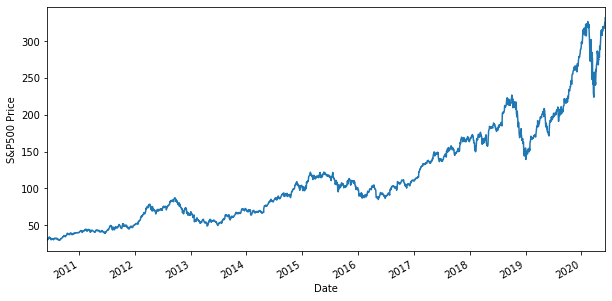

In [4]:
aapl['Adj Close'].plot(figsize=(10,5))
plt.ylabel("S&P500 Price")
plt.show()

We create 12 more technical features using Ta-Lib library. <br> <br>
1. "sma_5" and "sma_10" represent the simple moving average of 5 and 10 days, with equal weighting given to the price of each period.
2. "ema_5", "ema_10" and "ema_20" represent the exponential moving average of 5 and 10 days, and places a greater weight and significance on the most recent data points than SMA above.
3. "ATR" is the average true range, and it measures market volatility.
4. "ADX" is the average directional index that indicates the strength of a trend in price time series.
5. "CCI" is the commodity channel index, and is used to determine whether a stock is overbought or oversold.
6. "ROC" is the rate of change that measures the percentage change in price between the current price and the price a certain number of periods ago.
7. "RSI" is the relative strength index that compares the size of recent gains to recent losses, and it is intended to reveal the strength or weakness of a price trend from a range of closing prices over a time period.
8. "Williams %R" shows the relationship between the current closing price and the high and low prices over the latest n days equal to the input window length.
9. "SO%K" is stochastic %K that compares a close price and its price interval during a period of n past days and gives a signal meaning that a stock is oversold or overbought.

After that, we drop all the missing values. 

In [5]:
aapl['sma_5'] = talib.SMA(aapl['Adj Close'], timeperiod = 5)
aapl['sma_10'] = talib.SMA(aapl['Adj Close'], timeperiod = 10)
aapl['ema_5'] = aapl['Adj Close'].ewm(span = 5).mean().fillna(0)
aapl['ema_10'] = aapl['Adj Close'].ewm(span = 10).mean().fillna(0)
aapl['ema_20'] = aapl['Adj Close'].ewm(span = 20).mean().fillna(0)
aapl['ATR'] = talib.ATR(aapl['High'], aapl['Low'], aapl['Adj Close'], timeperiod = 14)
aapl['ADX'] = talib.ADX(aapl['High'], aapl['Low'], aapl['Adj Close'], timeperiod = 14)
typical_price = (aapl['High']+aapl['Low']+aapl['Adj Close']) / 3
Moving_average = typical_price/20
mean_deviation = (typical_price - Moving_average) / 20
aapl['CCI'] = (typical_price - Moving_average) / (0.015 * mean_deviation)
aapl['ROC'] = talib.ROC(aapl['Adj Close'], timeperiod = 14)
aapl['RSI'] = talib.RSI(aapl['Adj Close'], timeperiod = 14)
aapl['Williams %R'] = talib.WILLR(aapl['High'], aapl['Low'], aapl['Adj Close'], timeperiod = 14)
aapl['SO%K'] = (aapl['Adj Close'] - aapl['Low']) / (aapl['High'] - aapl['Low'])
aapl.dropna(inplace = True)

Now, we construct the 10-day ahead classification response values. <br><br>
"Pred" is 1 if the 10-day ahead price is greater than today's price. <br>
"Pred" is 0 if the 10-day ahead price is lower than today's price. <br>
We also check that "Pred" only has two classes. 

In [6]:
aapl['Pred'] = np.where(aapl['Adj Close'].shift(-10) > aapl['Adj Close'], 1, 0)
aapl['Pred'].unique()

array([1, 0], dtype=int64)

Next, let us separate explanatory variables (X) and the response variable (y). <br><br>
X: All columns of AAPL created above except "Pred".<br>
y: "Pred" column contains 10-day ahead classification. <br>

In [7]:
X = aapl.drop(columns = ['Pred'])
y = aapl['Pred']

In this step, we create the training set, validation set, and test set according to time split. <br>
<br>
With a time series like this, we typically want to use the oldest data as our training set and validation sets, and the newest data as our test set. This is so we can evaluate the performance of the model on the most recent data, which will more realistically simulate predictions on data we haven't seen yet.<br>
We split the dataset into the first 80% training + validation dataset and the last 20% Testing dataset. For the training + validation dataset, we use the first 80% of the data as the training set, and the remaining 20% as the validation set.<br>
<br>

In [8]:
train_size = int(0.8 * 0.8 * len(aapl))
train_val_size = int(0.8 * len(aapl))

In [9]:
X_train = X[:train_size]
X_val = X[train_size:train_val_size]
X_test = X[train_val_size:]
y_train = y[:train_size]
y_val = y[train_size:train_val_size]
y_test = y[train_val_size:]

Now we take a look at the data again after we append the features we created at the end of the original data.

In [10]:
aapl.head()

,Open,High,Low,Close,Adj Close,Volume,sma_5,sma_10,ema_5,ema_10,ema_20,ATR,ADX,CCI,ROC,RSI,Williams %R,SO%K,Pred
Date,,,,,,,,,,,,,,,,,,,
2010-07-15,35.461430,36.709999,35.328571,35.921429,31.097084,206216500,31.483930,31.334536,31.340148,31.521652,31.743044,5.446029,13.443206,1333.333333,-6.524192,47.782313,-194.275695,-3.063125,1
2010-07-16,36.168571,36.424286,35.487144,35.700001,30.905407,259964600,31.243516,31.352098,31.195233,31.409274,31.658636,5.437541,13.358206,1333.333333,-6.299192,46.199884,-201.175843,-4.889053,1
2010-07-19,35.697144,35.697144,34.228573,35.082859,30.371145,256119500,30.953878,31.335279,30.920536,31.220063,31.529610,5.391412,14.461411,1333.333333,-8.468108,42.022471,-208.922985,-2.626654,1
2010-07-20,34.700001,36.128571,34.287144,35.984287,31.151503,268737700,30.956106,31.375596,30.997525,31.207573,31.491905,5.417556,14.886930,1333.333333,-1.670753,49.241803,-192.444175,-1.702832,1
2010-07-21,37.869999,37.878571,36.285713,36.320000,31.442122,296417800,30.993452,31.320809,31.145724,31.250288,31.486963,5.511093,14.269427,1333.333333,1.077356,51.656117,-176.341165,-3.040818,1


Then we normalize data on training, validation, and test sets. <br><br>
It is clear that the values of different columns have different ranges like "RSI" and "ATR". So, we decide to scale down all values to range (0,1).  

In [11]:
scaler = MinMaxScaler(feature_range = (0,1))
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

We check that the sizes of training, validation and testing dataset are not to small to generate sampling errors. 

In [12]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1594, 18) (398, 18) (499, 18)
(1594,) (398,) (499,)


## Fitting models

### Logistic Classifier model

In this part, we are fine tuning the LogisticRegression Classifier using GridSearch to find the best combination of hyperparameter values. 

In [13]:
param_grid = {'C': [0.1, 1, 10, 100]
              }  
grid = GridSearchCV(LogisticRegression(max_iter = 5000), param_grid, refit = True, verbose = 3) 

grid.fit(X_train_scaled, y_train) 

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.564, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.469, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.439, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.523, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.484, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.467, total=   0.0s
[CV] C=10 ............................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=5000, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None, param_grid={'C': [0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

The best combination we get is shown below, and we name this model log_clf.

In [14]:
print(grid.best_params_) 
log_clf = grid.best_estimator_

{'C': 1}


We now compute the accuracy of the classification model on the validation and test datasets, by comparing the actual values we get from the historical data with the predicted values generated by our model. <br>

In [15]:
print('Scores on validation sets (%): ', log_clf.score(X_val_scaled, y_val)*100.0)
print('Accuracy on test sets (%): ', accuracy_score(y_test, log_clf.predict(X_test_scaled), normalize=True)*100.0)

Scores on validation sets (%):  69.59798994974874
Accuracy on test sets (%):  62.32464929859719


We can also take a look at the confusion matrix. <br> <br>
In the test set:<br>
Total number of values: 499 <br>
Total number of 0: 165 <br>
Total number of 1: 334 <br>
Number of predicting 0 as 0: 18 <br>
Number of predicting 1 as 1: 293 <br>

Recall here indicates up trends that are correctly detected by our model, and precision indicates up trends that are correctly predicted by our model. <br>
<br>
The F1 score is 0.62 for the Logistic model.

In [16]:
confusion_matrix(y_test, log_clf.predict(X_test_scaled))

array([[ 18, 147],
       [ 41, 293]], dtype=int64)

In [17]:
log_report = classification_report(y_test, log_clf.predict(X_test_scaled))
print(log_report)

              precision    recall  f1-score   support

           0       0.31      0.11      0.16       165
           1       0.67      0.88      0.76       334

    accuracy                           0.62       499
   macro avg       0.49      0.49      0.46       499
weighted avg       0.55      0.62      0.56       499



### SVM Classifier model 

Now, let us consider the Support Vector Machine classifier. <br> <br>
We are fine tuning the SVM classifier using grid search to find the best combination of hyperparameter values. 

In [18]:
param_grid2 = {'C' : [1, 10, 100],
               'gamma' : [0.05, 0.1, 1, 10],
               'kernel' : ['linear', 'rbf']
              }  
  
grid2 = GridSearchCV(SVC(), param_grid2, refit = True, verbose = 3) 
  
grid2.fit(X_train_scaled, y_train) 

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] C=1, gamma=0.05, kernel=linear ..................................
[CV] ...... C=1, gamma=0.05, kernel=linear, score=0.564, total=   0.0s
[CV] C=1, gamma=0.05, kernel=linear ..................................
[CV] ...... C=1, gamma=0.05, kernel=linear, score=0.492, total=   0.0s
[CV] C=1, gamma=0.05, kernel=linear ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ...... C=1, gamma=0.05, kernel=linear, score=0.465, total=   0.0s
[CV] C=1, gamma=0.05, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.05, kernel=rbf, score=0.564, total=   0.0s
[CV] C=1, gamma=0.05, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.05, kernel=rbf, score=0.544, total=   0.0s
[CV] C=1, gamma=0.05, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.05, kernel=rbf, score=0.480, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.564, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.492, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.465, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[CV] ....... C=100, gamma=1, kernel=linear, score=0.564, total=   0.1s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.501, total=   0.1s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.431, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.455, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.492, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.516, total=   0.1s
[CV] C=100, gamma=10, kernel=linear ..................................
[CV] ...... C=100, gamma=10, kernel=linear, score=0.564, total=   0.1s
[CV] C=100, gamma=10, kernel=linear ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    3.4s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 10, 100], 'gamma': [0.05, 0.1, 1, 10],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

The best combination of parameters we get after this grid search is listed below. Let's see the best combination we find, and we name this model svm_clf.

In [19]:
print(grid2.best_params_) 
svm_clf = grid2.best_estimator_

{'C': 1, 'gamma': 0.05, 'kernel': 'rbf'}


We now compute the accuracy of the SVM model on the validation and test datasets, by comparing the actual values we get from the historical data with the predicted values generated by our model. <br>

In [20]:
print('Scores on validation sets (%): ', svm_clf.score(X_val_scaled, y_val)*100.0)
print('Accuracy on test sets (%): ', accuracy_score(y_test, svm_clf.predict(X_test_scaled), normalize=True)*100.0)

Scores on validation sets (%):  68.09045226130654
Accuracy on test sets (%):  70.34068136272545


We also take a look at the confusion matrix. <br> <br>
In the test set:<br>
Total number of values: 499 <br>
Total number of 0: 165 <br>
Total number of 1: 334 <br>
Number of predicting 0 as 0: 34 <br>
Number of predicting 1 as 1: 317 <br>

The F1 score is 0.7 for the SVM model, and it is higher than what we got using the Logistic model above (0.62).

In [21]:
confusion_matrix(y_test, svm_clf.predict(X_test_scaled))

array([[ 34, 131],
       [ 17, 317]], dtype=int64)

In [22]:
svm_report = classification_report(y_test, svm_clf.predict(X_test_scaled))
print(svm_report)

              precision    recall  f1-score   support

           0       0.67      0.21      0.31       165
           1       0.71      0.95      0.81       334

    accuracy                           0.70       499
   macro avg       0.69      0.58      0.56       499
weighted avg       0.69      0.70      0.65       499



### Comparing the two models above for AAPL

1. Learning Curve

The learning curve for Logistic shows a little gap between the validation and train, which means the Logistic model performs slightly better on the training data than on the validation data, which means the model is slightly overfitting. <br>
The learning curve for SVM shows an approximately convergent trend between the validation and train, which means the SVM model is neither overfitting nor underfitting. 

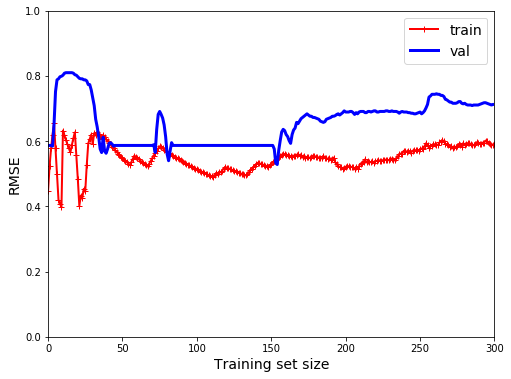

In [23]:
def plot_learning_curves(model, X_train_scaled, y_train, X_val_scaled, y_val):
    train_errors, val_errors = [], []
    for m in range(10, len(X_train_scaled)):
        model.fit(X_train_scaled[:m], y_train[:m])
        y_train_predict = model.predict(X_train_scaled[:m])
        y_val_predict = model.predict(X_val_scaled)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.subplots(1, figsize=(8,6))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14) 
plot_learning_curves(log_clf, X_train_scaled, y_train, X_val_scaled, y_val)
plt.axis([0, 300, 0, 1])           
plt.show()  

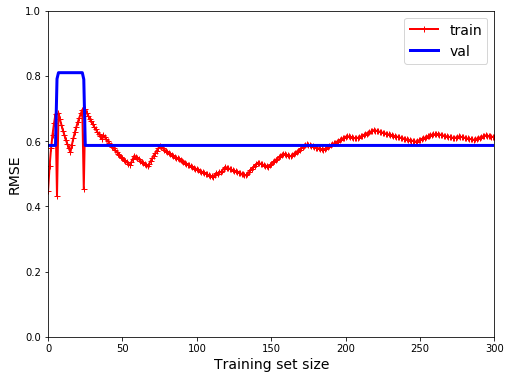

In [24]:
plot_learning_curves(svm_clf, X_train_scaled, y_train, X_val_scaled, y_val)
plt.axis([0, 300, 0, 1])           
plt.show() 

2. Receiver Operating Characteristic (ROC) Curve 

Although the two curves kind of overlap each other toward the upper right corner of the graph, generally the ROC curve of the SVM model (BLUE) is higher. So we can say that the SVM model performs better for AAPL.

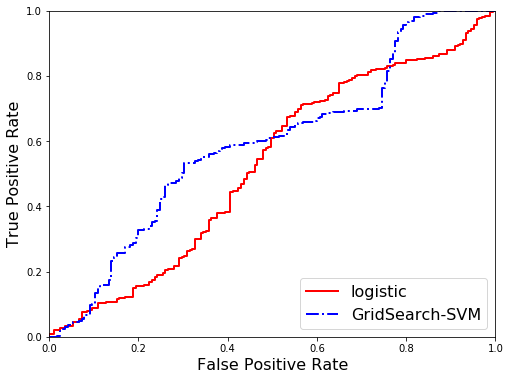

In [25]:
models = [log_clf, svm_clf]
model_names = ["logistic", "GridSearch-SVM"]
styles = ['r-', 'b-.']

cv=10
plt.figure(figsize=(8, 6))
ROCAUC = []
for idx, model in enumerate(models):  
    if model == svm_clf:
        y_scores = model.decision_function(X_test_scaled)
    else:
        y_scores = model.predict_proba(X_test_scaled)[:,1]                                
    fpr, tpr, thresholds = roc_curve(y_test,y_scores)
    ROCAUC.append(roc_auc_score(y_test, y_scores))
    plt.plot(fpr, tpr, styles[idx],
             linewidth=2, label=model_names[idx])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.show()

Another way to compare these two models is to measure the area under the curve (AUC). ROC AUC for the Logistic model is 0.524, which is less than 0.5917 for SVM model. It confirms that the SVM model performs better for stock AAPL.

In [26]:
for idx, score in enumerate(ROCAUC):
    print("Model: {}, ROC-AUC:{:.4}".format(model_names[idx], score))

Model: logistic, ROC-AUC:0.524
Model: GridSearch-SVM, ROC-AUC:0.5917


3. 10-fold Boxplot 

We also generate the plot that shows the 10 scores for the 10 cross-validation folds for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores. We can see that the variance of the scores resulted from the Logistic model is way larger than that of SVM model.

In [27]:
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

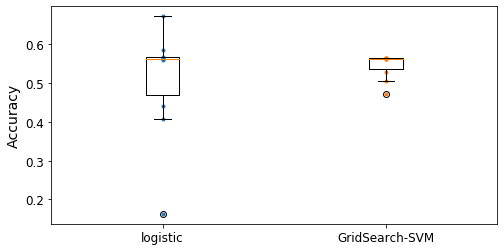

In [28]:
plt.figure(figsize=(8, 4))
cv_scores=[]
for idx, model in enumerate(models):
    cv_scores.append(cross_val_score(model, X_train_scaled, y_train, cv=10))
    plt.plot([1+idx]*10, cv_scores[-1], ".")
plt.boxplot(cv_scores, labels=model_names)
plt.ylabel("Accuracy", fontsize=14)
plt.show()

4. In-sample Performance

The mean absolute error for the Logistic model on the training set is slightly higher than the SVM model. 

In [29]:
log_mae = mean_absolute_error(y_train, log_clf.predict(X_train_scaled))
svm_mae = mean_absolute_error(y_train, svm_clf.predict(X_train_scaled))
print(log_mae)
print(svm_mae)

0.41969887076537016
0.3989962358845671


5. 10-fold Cross-validation Scores 

The scores we generated below confirm that the mean absolute error for the SVM model is smaller, and the variance is also lower.

In [30]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [31]:
log_CV_scores = -cross_val_score(log_clf, X_train_scaled,
                                    y_train,scoring="neg_mean_absolute_error",
                                    cv=10)
display_scores(log_CV_scores)

Scores: [0.4375     0.4375     0.43125    0.8375     0.55974843 0.44025157
 0.32704403 0.59119497 0.41509434 0.43396226]
Mean: 0.4911045597484277
Standard deviation: 0.13512735414768967


In [32]:
svm_CV_scores = -cross_val_score(svm_clf, X_train_scaled,
                                    y_train,scoring="neg_mean_absolute_error",
                                    cv=10)
display_scores(svm_CV_scores)

Scores: [0.4375     0.4375     0.4375     0.49375    0.43396226 0.43396226
 0.43396226 0.52830189 0.47169811 0.43396226]
Mean: 0.45420990566037733
Standard deviation: 0.031363049787910165


Finally, we put the scores together in one chart for better comparison.

In [33]:
best_models = [log_clf, svm_clf]

scores = []
for idx, model in enumerate(best_models):
    y_pred = model.predict(X_test_scaled)
    if model == svm_clf:
        y_scores = model.decision_function(X_test_scaled)
    else:
        y_scores = model.predict_proba(X_test_scaled)[:,1]
    scores.append([accuracy_score(y_test, y_pred),
                   precision_score(y_test, y_pred),
                   recall_score(y_test, y_pred),
                   roc_auc_score(y_test, y_scores)])

In [34]:
pd.DataFrame(data=scores,
             index = model_names,
             columns= ["accuracy", "precision", "recall", "ROCAUC"])

,accuracy,precision,recall,ROCAUC
logistic,0.623246,0.665909,0.877246,0.523970
GridSearch-SVM,0.703407,0.707589,0.949102,0.591726


**Conclusion**: the SVM model performs better than the Logistic model for the AAPL dataset. While since ROC curves for both models are only slightly better than the dummy classifier, we might admit that both Logistic and SVM models are not ideal for predicting. 

## Checking model consistency with the MSFT dataset 

### Preprocessing MSFT stock price data

First, we do the same thing as above to preprocess the MSFT data dataset.<br><br>
We download the price data for Microsoft Corporation from 2010.06.07 to 2020.06.07, create the same features as above, drop the missing values in the dataset, and separate X and y. 

In [35]:
msft = pd.read_csv('MSFT.csv')
msft['Date'] = pd.to_datetime(msft['Date'], format = '%Y-%m-%d')
msft.set_index(['Date'], inplace=True)

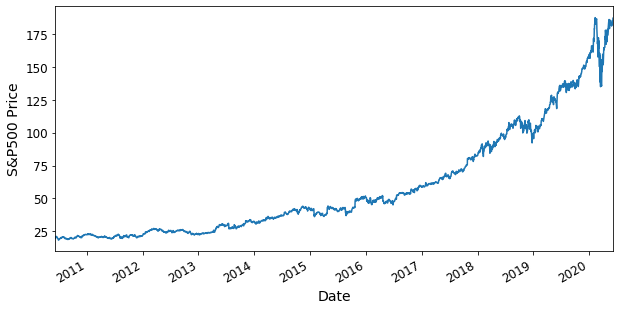

In [36]:
msft['Adj Close'].plot(figsize=(10,5))
plt.ylabel("S&P500 Price")
plt.show()

In [37]:
msft['sma_5'] = talib.SMA(msft['Adj Close'], timeperiod = 5)
msft['sma_10'] = talib.SMA(msft['Adj Close'], timeperiod = 10)
msft['ema_5'] = msft['Adj Close'].ewm(span = 5).mean().fillna(0)
msft['ema_10'] = msft['Adj Close'].ewm(span = 10).mean().fillna(0)
msft['ema_20'] = msft['Adj Close'].ewm(span = 20).mean().fillna(0)
msft['ATR'] = talib.ATR(msft['High'], msft['Low'], msft['Adj Close'], timeperiod = 14)
msft['ADX'] = talib.ADX(msft['High'], msft['Low'], msft['Adj Close'], timeperiod = 14)
typical_price = (msft['High']+msft['Low']+msft['Adj Close']) / 3
Moving_average = typical_price/20
mean_deviation = (typical_price - Moving_average) / 20
msft['CCI'] = (typical_price - Moving_average) / (0.015 * mean_deviation)
msft['ROC'] = talib.ROC(msft['Adj Close'], timeperiod = 14)
msft['RSI'] = talib.RSI(msft['Adj Close'], timeperiod = 14)
msft['Williams %R'] = talib.WILLR(msft['High'], msft['Low'], msft['Adj Close'], timeperiod = 14)
msft['SO%K'] = (msft['Adj Close'] - msft['Low']) / (msft['High'] - msft['Low'])
msft.dropna(inplace = True)

In [38]:
msft['Pred'] = np.where(msft['Adj Close'].shift(-10) > msft['Adj Close'], 1, 0)
msft['Pred'].unique()

array([1, 0], dtype=int64)

Now, we call the explanatory variable X2, and the response varialble y2.

In [39]:
X2 = msft.drop(columns = ['Pred'])
y2 = msft['Pred']

We split the dataset into training set, validation set, and test set. The proportions of each set is the same as above. Then, we normalize data to range (0,1) as before. 

In [40]:
train_size2 = int(0.8 * 0.8 * len(msft))
train_val_size2 = int(0.8 * len(msft))

In [41]:
X2_train = X2[:train_size2]
X2_val = X2[train_size2:train_val_size2]
X2_test = X2[train_val_size2:]
y2_train = y2[:train_size2]
y2_val = y2[train_size2:train_val_size2]
y2_test = y2[train_val_size2:]

In [42]:
scaler = MinMaxScaler(feature_range = (0,1))
X2_train_scaled = scaler.fit_transform(X2_train)
X2_val_scaled = scaler.fit_transform(X2_val)
X2_test_scaled = scaler.fit_transform(X2_test)

Finally, we check that the sizes of training, validation and testing dataset are not to small to generate sampling errors. 

In [43]:
print(X2_train.shape, X2_val.shape, X2_test.shape)
print(y2_train.shape, y2_val.shape, y2_test.shape)

(1594, 18) (398, 18) (499, 18)
(1594,) (398,) (499,)


### Logistic Classifier model

We use grid search to find the best combination of hyperparameters and fit the LogisticRegression Classifier model.

In [44]:
param_grid3 = {'C': [0.01, 0.1, 1, 10, 100]
              }  
grid3 = GridSearchCV(LogisticRegression(max_iter = 5000), param_grid3, refit = True, verbose = 3) 

grid3.fit(X2_train_scaled, y2_train) 

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.590, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.590, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.591, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.613, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.602, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.591, total=   0.0s
[CV] C=1 .............................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=5000, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None, param_grid={'C': [0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

Below are the best hyperparameter values we get, and we call the model "log2_clf". 

In [45]:
print(grid3.best_params_)
log2_clf = grid3.best_estimator_

{'C': 0.1}


We now compute the accuracy of the classification model on the validation and test datasets, by comparing the actual values we get from the historical data with the predicted values generated by our model. <br>


In [46]:
print('Scores on validation sets (%): ', log2_clf.score(X2_val_scaled, y2_val)*100.0)
print('Accuracy on test sets (%): ', accuracy_score(y2_test, log2_clf.predict(X2_test_scaled), normalize=True)*100.0)

Scores on validation sets (%):  59.54773869346733
Accuracy on test sets (%):  65.53106212424849


We also take a look at the confusion matrix. <br> <br>
In the test set:<br>
Total number of values: 499 <br>
Total number of 0: 156 <br>
Total number of 1: 343 <br>
Number of predicting 0 as 0: 7 <br>
Number of predicting 1 as 1: 320 <br>

The F1 score is 0.66 for the Logistic model.

In [47]:
confusion_matrix(y2_test, log2_clf.predict(X2_test_scaled))

array([[  7, 149],
       [ 23, 320]], dtype=int64)

In [48]:
log2_report = classification_report(y2_test, log2_clf.predict(X2_test_scaled))
print(log2_report)

              precision    recall  f1-score   support

           0       0.23      0.04      0.08       156
           1       0.68      0.93      0.79       343

    accuracy                           0.66       499
   macro avg       0.46      0.49      0.43       499
weighted avg       0.54      0.66      0.57       499



### SVM Classifier model

Now we consider the second algorithm, and fit the SVM classifier model by finding out the hyperparameter values first.<br>

In [49]:
param_grid4 = {'C' : [1, 10, 100],
               'gamma' : [0.05, 0.1, 1, 10], 
              'kernel': ['linear', 'rbf']}  
  
grid4 = GridSearchCV(SVC(), param_grid4, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid4.fit(X2_train_scaled, y2_train) 

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] C=1, gamma=0.05, kernel=linear ..................................
[CV] ...... C=1, gamma=0.05, kernel=linear, score=0.620, total=   0.0s
[CV] C=1, gamma=0.05, kernel=linear ..................................
[CV] ...... C=1, gamma=0.05, kernel=linear, score=0.551, total=   0.0s
[CV] C=1, gamma=0.05, kernel=linear ..................................
[CV] ...... C=1, gamma=0.05, kernel=linear, score=0.608, total=   0.0s
[CV] C=1, gamma=0.05, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ......... C=1, gamma=0.05, kernel=rbf, score=0.590, total=   0.0s
[CV] C=1, gamma=0.05, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.05, kernel=rbf, score=0.590, total=   0.0s
[CV] C=1, gamma=0.05, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.05, kernel=rbf, score=0.591, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.620, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.551, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.608, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.654, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[CV] ....... C=100, gamma=1, kernel=linear, score=0.640, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.414, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.579, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.513, total=   0.1s
[CV] C=100, gamma=10, kernel=linear ..................................
[CV] ...... C=100, gamma=10, kernel=linear, score=0.594, total=   0.1s
[CV] C=100, gamma=10, kernel=linear ..................................
[CV] ...... C=100, gamma=10, kernel=linear, score=0.553, total=   0.1s
[CV] C=100, gamma=10, kernel=linear ..................................
[CV] ...... C=100, gamma=10, kernel=linear, score=0.640, total=   0.1s
[CV] C=100, gamma=10, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    3.0s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 10, 100], 'gamma': [0.05, 0.1, 1, 10],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

The best hyperparameter values we find are as the following, and we call the model "svm2_clf". 

In [50]:
svm2_clf = grid4.best_estimator_
print(grid4.best_params_) 

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


We now compute the accuracy of the SVM model on the validation and test datasets, by comparing the actual values we get from the historical data with the predicted values generated by our model. <br>

In [51]:
print('Scores on validation sets (%): ', svm2_clf.score(X2_val_scaled, y2_val)*100.0)
print('Accuracy on test sets (%): ', accuracy_score(y2_test, svm2_clf.predict(X2_test_scaled), normalize=True)*100.0)

Scores on validation sets (%):  63.81909547738693
Accuracy on test sets (%):  65.53106212424849


We also take a look at the confusion matrix. <br> <br>
In the test set:<br>
Total number of values: 499 <br>
Total number of 0: 156 <br>
Total number of 1: 343 <br>
Number of predicting 0 as 0: 3 <br>
Number of predicting 1 as 1: 324 <br>

The F1 score is 0.66 for the SVM model.

In [52]:
confusion_matrix(y2_test, svm2_clf.predict(X2_test_scaled))

array([[  3, 153],
       [ 19, 324]], dtype=int64)

In [53]:
svm2_report = classification_report(y2_test, svm2_clf.predict(X2_test_scaled))
print(svm2_report)

              precision    recall  f1-score   support

           0       0.14      0.02      0.03       156
           1       0.68      0.94      0.79       343

    accuracy                           0.66       499
   macro avg       0.41      0.48      0.41       499
weighted avg       0.51      0.66      0.55       499



### Compare the two models above for MSFT

1. Learning Curve

The learning curves for both Logistic and SVM show approximately convergent trends between the validation and train as the size of the training set gets larger. <br>

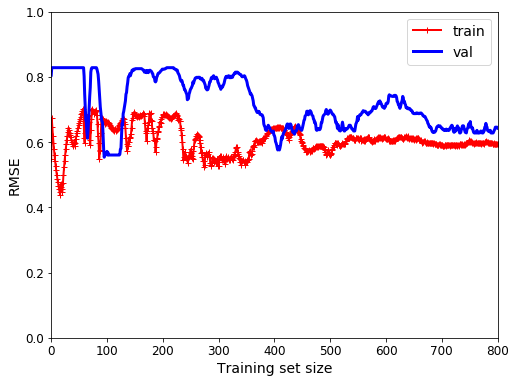

In [54]:
def plot_learning_curves(model, X_train_scaled, y_train, X_val_scaled, y_val):
    train_errors, val_errors = [], []
    for m in range(10, len(X_train_scaled)):
        model.fit(X_train_scaled[:m], y_train[:m])
        y_train_predict = model.predict(X_train_scaled[:m])
        y_val_predict = model.predict(X_val_scaled)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.subplots(1, figsize=(8,6))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14) 
plot_learning_curves(log2_clf, X2_train_scaled, y2_train, X2_val_scaled, y2_val)
plt.axis([0, 800, 0, 1])           
plt.show()  

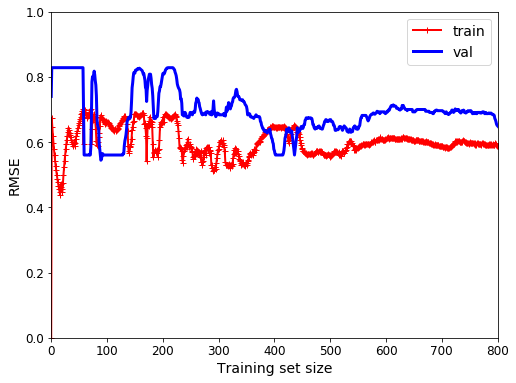

In [55]:
plot_learning_curves(svm2_clf, X2_train_scaled, y2_train, X2_val_scaled, y2_val)
plt.axis([0, 800, 0, 1])           
plt.show()

2. Receiver Operating Characteristic (ROC) Curve 

Although the two curves kind of overlap each other toward the upper right corner of the graph, generally the ROC curve of both models are not good enough. 

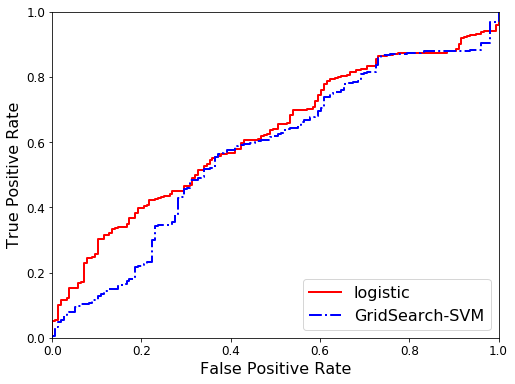

In [56]:
models2 = [log2_clf, svm2_clf]
model_names2 = ["logistic", "GridSearch-SVM"]
styles = ['r-', 'b-.']

cv=10
plt.figure(figsize=(8, 6))
ROCAUC = []
for idx, model in enumerate(models2):   
    if model == svm2_clf:
        y2_scores = model.decision_function(X2_test_scaled)
    else:
        y2_scores = model.predict_proba(X2_test_scaled)[:,1]                                  
    fpr, tpr, thresholds = roc_curve(y2_test,y2_scores)
    ROCAUC.append(roc_auc_score(y2_test, y2_scores))
    plt.plot(fpr, tpr, styles[idx],
             linewidth=2, label=model_names2[idx])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.show()

The higher ROC AUC for the Logistic model indicates that the Logistic model performs a little bit better.

In [57]:
for idx, score in enumerate(ROCAUC):
    print("Model: {}, ROC-AUC:{:.4}".format(model_names2[idx], score))

Model: logistic, ROC-AUC:0.6213
Model: GridSearch-SVM, ROC-AUC:0.5745


3. 10-fold Boxplot 

We also generate the plot that shows the 10 scores for the 10 cross-validation folds for each model. We can see that the variance of the scores resulted from the Logistic model is smaller than that of SVM model.

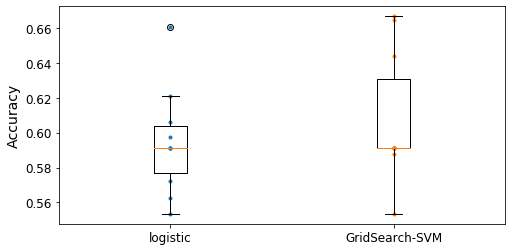

In [58]:
plt.figure(figsize=(8, 4))
cv_scores=[]
for idx, model in enumerate(models2):
    cv_scores.append(cross_val_score(model, X2_train_scaled, y2_train, cv=10))
    plt.plot([1+idx]*10, cv_scores[-1], ".")
plt.boxplot(cv_scores, labels=model_names2)
plt.ylabel("Accuracy", fontsize=14)
plt.show()

4. In-sample Performance

The mean absolute error for the Logistic model on the training set is slightly lower than the SVM model. 

In [59]:
log2_mae = mean_absolute_error(y2_train, log2_clf.predict(X2_train_scaled))
svm2_mae = mean_absolute_error(y2_train, svm2_clf.predict(X2_train_scaled))
print(log2_mae)
print(svm2_mae)

0.3707653701380176
0.40087829360100374


5. 10-fold Cross-validation Scores 

The scores we generated below show that the mean absolute error and variance for both models are similar. 

In [60]:
log2_CV_scores = -cross_val_score(log2_clf, X2_train_scaled,
                                    y2_train,scoring="neg_mean_absolute_error",
                                    cv=10)
display_scores(log2_CV_scores)

Scores: [0.37888199 0.39375    0.4375     0.40251572 0.40880503 0.40880503
 0.42767296 0.33962264 0.44654088 0.40880503]
Mean: 0.4052899283175124
Standard deviation: 0.02903039028538168


In [61]:
svm2_CV_scores = -cross_val_score(svm2_clf, X2_train_scaled,
                                    y2_train,scoring="neg_mean_absolute_error",
                                    cv=10)
display_scores(svm2_CV_scores)

Scores: [0.33540373 0.4125     0.35625    0.40880503 0.40880503 0.40880503
 0.33333333 0.40880503 0.44654088 0.40880503]
Mean: 0.3928053097777257
Standard deviation: 0.03567001015641226


Finally, we put the scores together in one chart for better comparison.

In [62]:
best_models2 = [log2_clf, svm2_clf]

scores = []
for idx, model in enumerate(best_models2):
    y2_pred = model.predict(X2_test_scaled)
    if model == svm2_clf:
        y2_scores = model.decision_function(X2_test_scaled)
    else:
        y2_scores = model.predict_proba(X2_test_scaled)[:,1]
    scores.append([accuracy_score(y2_test, y2_pred),
                   precision_score(y2_test, y2_pred),
                   recall_score(y2_test, y2_pred),
                   roc_auc_score(y2_test, y2_scores)])

In [63]:
pd.DataFrame(data=scores,
             index = model_names2,
             columns= ["accuracy", "precision", "recall", "ROCAUC"])

,accuracy,precision,recall,ROCAUC
logistic,0.655311,0.682303,0.932945,0.621272
GridSearch-SVM,0.651303,0.677895,0.938776,0.574494


**Conclusion**: generally speaking, although Logistic model performs slightly better in terms of accuracy and ROCAUC, both models are not outperforming the dummy classifier much. 

## Result Discussion & Future Enhancement

Based on our discussion above, we get a generalized result that SVM model performs better than Logistic model on AAPL dataset. But both models have similar performance on MSFT dataset. Generally speaking, our models are not good enough for predicting chosen stock price trend. <br>
In this project, we trained two different models basing on the Logistic algorithm and the SVM algorithm. The data we used are from two different stocks over the past 10 years, and we calculated and used 18 features as our explanatory variable (X).<br>
Future improvement of this project will involve adding more features into the explanatory variables, and the more parameters we add, the higher accuracy we can get. For example, we could consider sentimental analysis by generating  sentimental scores which indicate investors' confidence on stock after viewing recent news. Also, we can try different combinations of original parameters and algorithms like time-series. Futhermore, we will take correlation among different stocks in the same industry into account.  We may also compare the algorithms on more general stock field, instead of on specific stock data.

## References

1. Sadia, K. Hiba, et al. “Stock Market Prediction Using Machine Learning Algorithms.” International Journal of Engineering and Advanced Technology (IJEAT), vol. 8, no. 4, Apr. 2019, https://www.ijeat.org/wp-content/uploads/papers/v8i4/D6321048419.pdf.

2. Moukalled, Mariam, et al. "Automated Stock Price Prediction Using Machine Learning" https://www.aclweb.org/anthology/W19-6403.pdf

3. J. Gong and S. Sun, "A New Approach of Stock Price Prediction Based on Logistic Regression Model," 2009 International Conference on New Trends in Information and Service Science, Beijing, 2009, pp. 1366-1371, doi: 10.1109/NISS.2009.267.